# Polynomial and Interaction Regression
## 1. Introduction
This notebook extends the linear model by introducing nonlinear and interaction
features to better capture stellar physics.

## 2. Dataset Definition

In [66]:
import numpy as np
import matplotlib.pyplot as plt

M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

## 3. Visualization with Tempeture Enconding

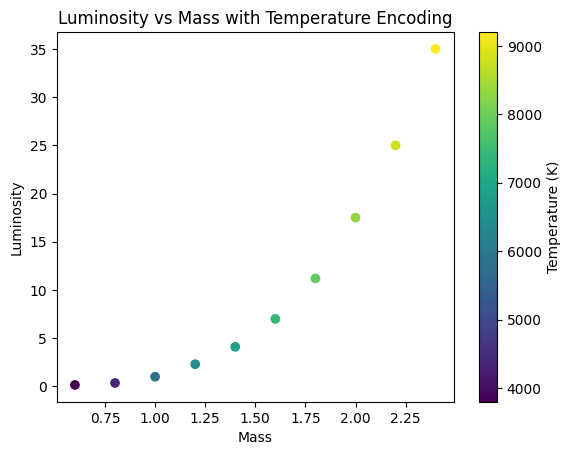

In [67]:
plt.scatter(M, L, c=T)
plt.colorbar(label="Temperature (K)")
plt.xlabel("Mass")
plt.ylabel("Luminosity")
plt.title("Luminosity vs Mass with Temperature Encoding")
plt.show()

## 4. Feature Engineering
We construct the design matrix:

$$ X = [ M, T, M², M·T ] $$


In [68]:
X = np.column_stack([
    M,
    T,
    M**2,
    M * T
]) 

Now we define a normalize function:

In [69]:

def normalize(X):
    """
    Normalize features using mean and standard deviation
    to avoid numerical instability during gradient descent.
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X - mu) / sigma, mu, sigma

In [70]:
X_norm, mu, sigma = normalize(X)

## 5. Loss and Gradients (Vectorized)

In [71]:
def predict_multi(X, w, b):
    return X @ w + b

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def gradients_multi(X, L, w, b):
    N = len(L)
    error = predict_multi(X, w, b) - L
    dw = (2/N) * X.T @ error
    db = (2/N) * np.sum(error)
    return dw, db

## 6. Training and Convergence

In [72]:
def train_multi(X, L, lr=0.01, epochs=8000):
    w = np.zeros(X.shape[1])
    b = 0.0
    losses = []

    for _ in range(epochs):
        dw, db = gradients_multi(X, L, w, b)
        w -= lr * dw
        b -= lr * db
        losses.append(mse(L, predict_multi(X, w, b)))

    return w, b, losses

## 7. Feature Selection Experiment

M1
Final loss: 7.200293968846395
Learned weights: [ 27.81179633 -17.72111762]
Learned bias: 10.359999999999967
----------------------------------------


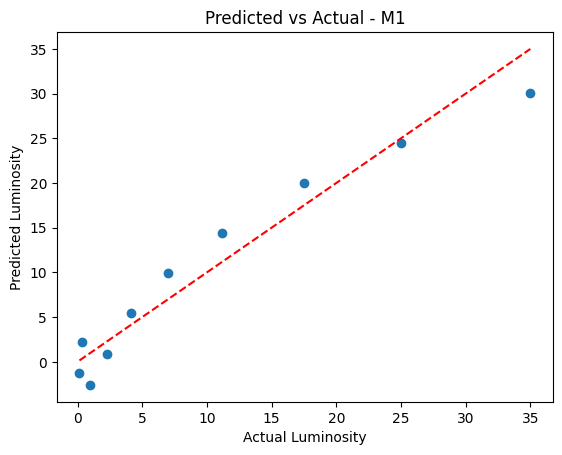

M2
Final loss: 1.5474480420172918
Learned weights: [-1.81689375 -6.16530245 18.58517489]
Learned bias: 10.359999999999955
----------------------------------------


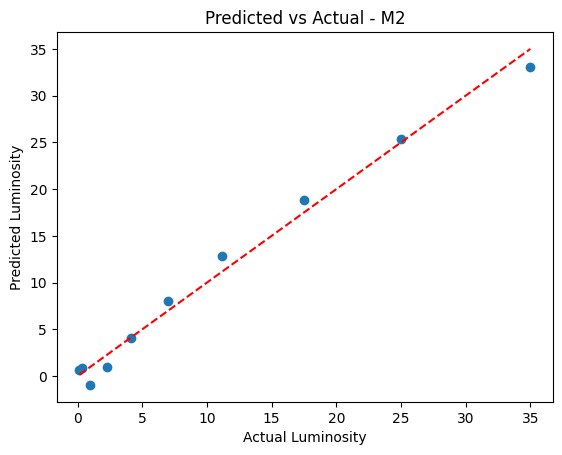

M3
Final loss: 1.5497887108662063
Learned weights: [-3.85172467 -6.95907046 14.92291273  6.44600249]
Learned bias: 10.359999999999955
----------------------------------------


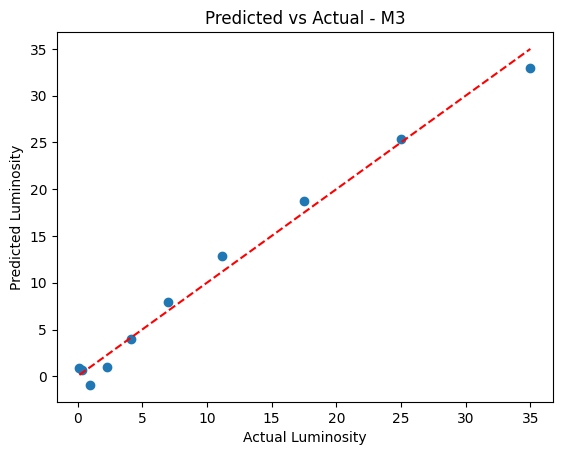

In [77]:
models = {
    "M1": X_norm[:, :2],
    "M2": X_norm[:, :3],
    "M3": X_norm
}

for name, Xm in models.items():
    w, b, losses = train_multi(Xm, L)
    
    # Predictions on training data
    L_pred = predict_multi(Xm, w, b)
    
    print(f"{name}")
    print("Final loss:", losses[-1])
    print("Learned weights:", w)
    print("Learned bias:", b)
    print("-" * 40)
    
    # Predicted vs Actual plot
    plt.figure()
    plt.scatter(L, L_pred)
    plt.plot([L.min(), L.max()], [L.min(), L.max()], 'r--')
    plt.xlabel("Actual Luminosity")
    plt.ylabel("Predicted Luminosity")
    plt.title(f"Predicted vs Actual - {name}")
    plt.show()

## 8. Cost vs Interaction Coefficient

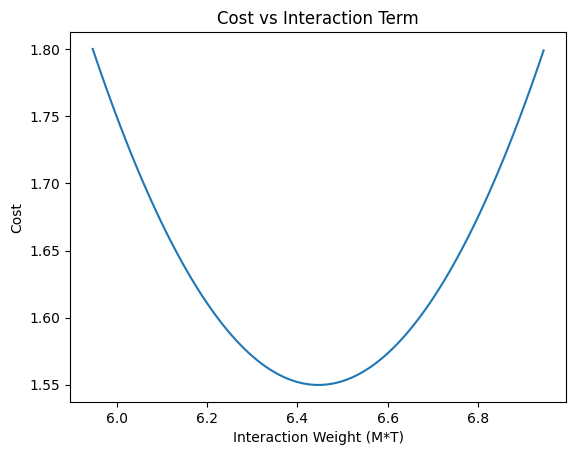

In [74]:
w, b, _ = train_multi(X_norm, L)
w_mt_vals = np.linspace(w[3] - 0.5, w[3] + 0.5, 100)
costs = []

for val in w_mt_vals:
    w_temp = w.copy()
    w_temp[3] = val
    costs.append(mse(L, predict_multi(X_norm, w_temp, b)))

plt.plot(w_mt_vals, costs)
plt.xlabel("Interaction Weight (M*T)")
plt.ylabel("Cost")
plt.title("Cost vs Interaction Term")
plt.show()

The curve has a clear minimum, meaning that there is a specific value of this
interaction term that gives the lowest error. When the interaction weight is
smaller or larger than this optimal value, the cost increases.

This tells us that the interaction between mass and temperature is important for
predicting stellar luminosity. If this interaction were not useful, changing its
coefficient would not significantly affect the cost. Instead, the model is
sensitive to this term, showing that it improves prediction accuracy.



## 9. Inference Demo

In [75]:
M_new = 1.3
T_new = 6600

X_new = np.array([M_new, T_new, M_new**2, M_new*T_new])
X_new_norm = (X_new - mu) / sigma

L_pred = predict_multi(X_new_norm, w, b)

print("Predicted luminosity:", L_pred)

Predicted luminosity: 2.5224181569384


The predicted value is consistent with nearby stars in the dataset,
suggesting reasonable interpolation behavior.
